In [1]:
import jax
import jax.numpy as jnp
import requests
from flax.traverse_util import flatten_dict
from PIL import Image
from transformers import AutoImageProcessor

from configuration_vit import ModifiedViTConfig, ViTConfig
from modeling_flax_vit import (
    FlaxSequenceClassifierOutput,
    FlaxViTForImageClassification,
)

from einshape import jax_einshape as einshape

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)  # type: ignore

base_config = ViTConfig.from_pretrained("google/vit-base-patch16-224")

config = ModifiedViTConfig.from_dict(base_config.to_dict())
config.attention_type = "sparsemax"
config.attention_temperature = 10.0
config.output_intermediates = True

image_processor = AutoImageProcessor.from_pretrained(
    "google/vit-base-patch16-224",
)
model = FlaxViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    config=config,
)
assert isinstance(model, FlaxViTForImageClassification)

inputs = image_processor(images=image, return_tensors="np")
outputs, intermediates = model(**inputs)
assert isinstance(outputs, FlaxSequenceClassifierOutput)
logits = outputs.logits

# model predicts one of the 1000 ImageNet classes
predicted_class_idx = jax.numpy.argmax(logits, axis=-1)
# print("Predicted class:", model.config.id2label[predicted_class_idx.item()])

In [9]:
import pickle as pl
pl.dump(intermediates, open('intermediates.pkl', 'wb'))

In [3]:
filtered_intermediates = {k: v[0] for k, v in flatten_dict(intermediates).items() if k[-1] == "a"}
all_attn = jnp.concatenate(list(filtered_intermediates.values()), axis=0)
all_attn_flat = einshape("bh...->(bh)...", all_attn)

In [4]:
def stable_rank(a):
    return jnp.linalg.norm(a, "fro") ** 2 / jnp.linalg.norm(a, 2) ** 2

def low_rank_approx(a, rank):
    u, s, v = jnp.linalg.svd(a, full_matrices=False)
    u = u[:, :rank]
    s = s[:rank]
    v = v[:rank, :]
    return u @ jnp.diag(s) @ v

In [5]:
stable_rank_values = jax.vmap(stable_rank)(all_attn_flat)
top_idx = jnp.argsort(jnp.array(stable_rank_values), descending=True)

In [8]:
all_attn_flat[top_idx[k]].shape

(197, 197)

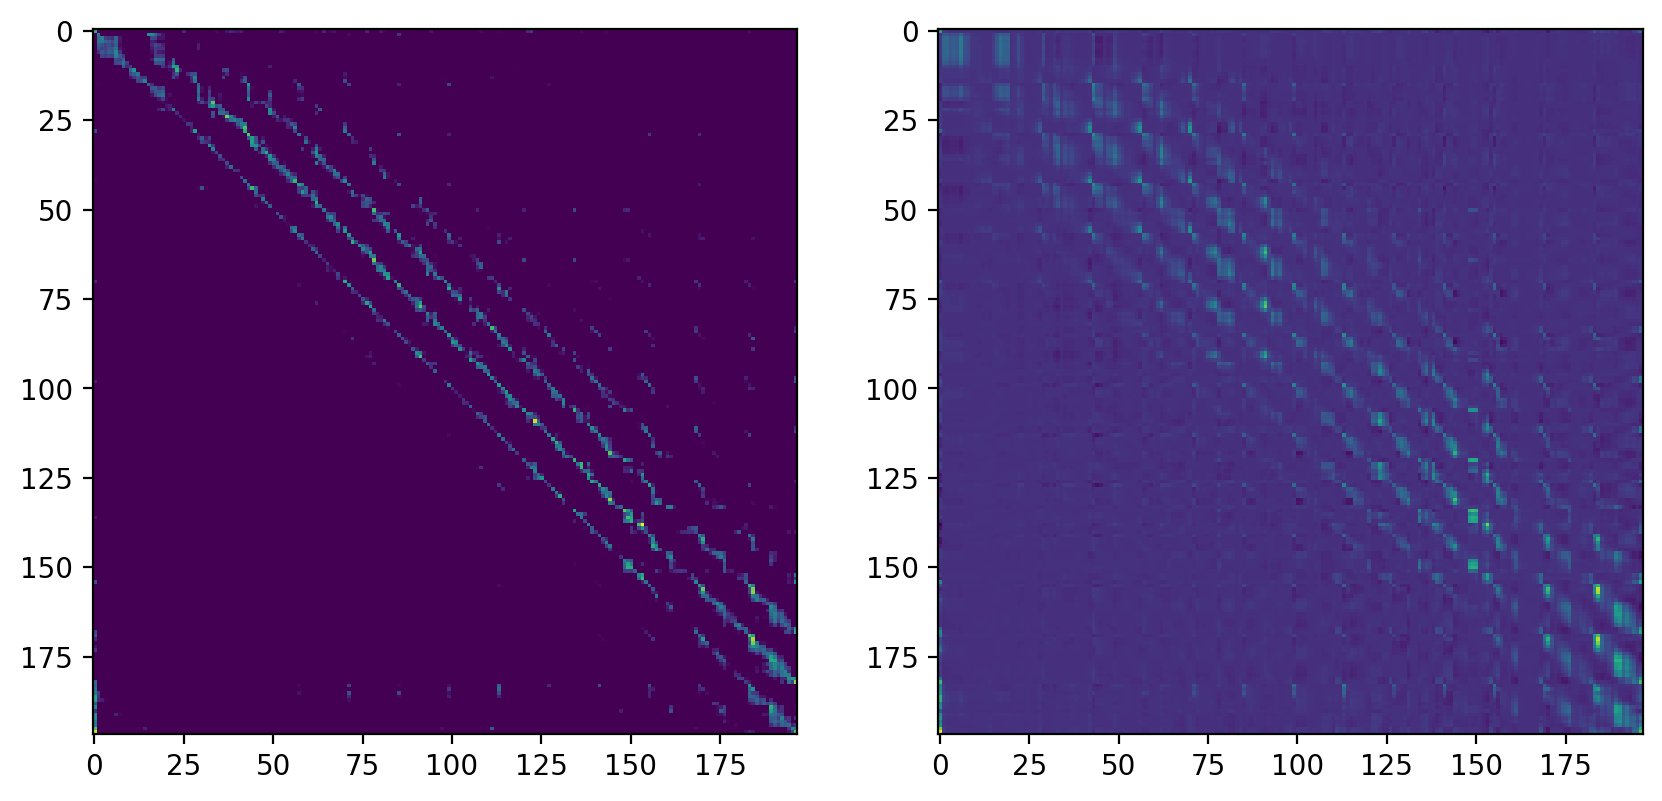

In [6]:
k = 10
rank = 16
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(all_attn_flat[top_idx[k]])
ax[1].imshow(low_rank_approx(all_attn_flat[top_idx[k]], rank))

Text(0, 0.5, 'Stable Rank')

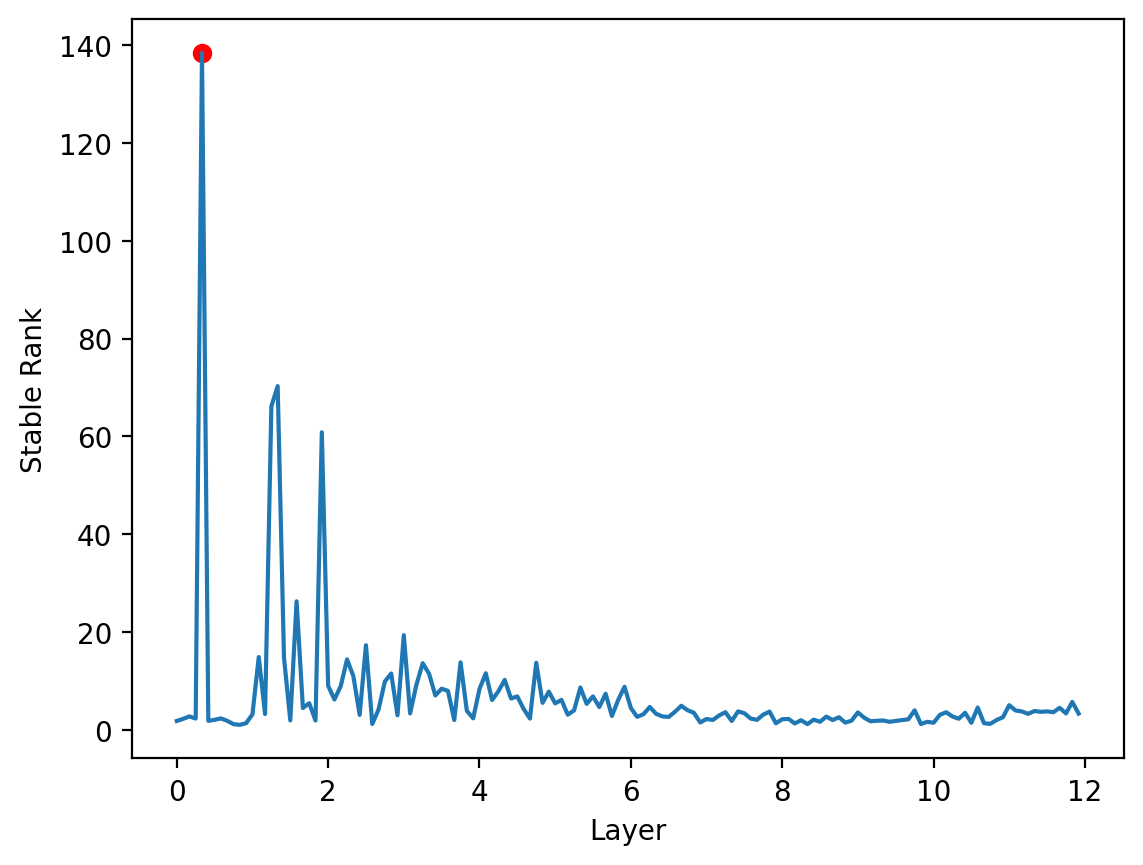

In [64]:
plt.plot(jnp.arange(144) / 12, stable_rank_values)
plt.scatter(top_idx / 12, stable_rank_values[top_idx], color="red")
plt.xlabel("Layer")
plt.ylabel("Stable Rank")